# Constraining parameters

So, how to use IMAGINE to constrain a particular set of models given a particular dataset?
This section dicusses various approachs to this problem using different tools available within IMAGINE.
It assumes that the reader went through the parts of the documentation which describe the [main
components of IMAGINE](../docs/source/components.rst) and/or went through some of the [tutorials](tutorial_one.ipynb).


In [2]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

import imagine as img


## Setting up an example problem

We start by setting up an example problem similar to the one in [first tutorial](tutorial_one.ipynb). 

First we generate mock data.

In [3]:
# Prepares fields/grid for generating mock data
one_d_grid = img.fields.UniformGrid(box=[[0,2*np.pi]*u.kpc,
                                         [0,0]*u.kpc,
                                         [0,0]*u.kpc],
                                    resolution=[30,1,1])

ne_field = img.fields.CosThermalElectronDensity(grid=one_d_grid, 
                                                parameters={'n0': 0.5*u.cm**-3,
                                                            'a': 1.0/u.kpc*u.rad,
                                                            'b': 0.0/u.kpc*u.rad,
                                                            'c': 0.0/u.kpc*u.rad,
                                                            'alpha': 30.*u.deg,
                                                            'beta':  90.*u.deg,
                                                            'gamma': 90.*u.deg})

B_field = img.fields.ConstantMagneticField(grid=one_d_grid, 
                                           parameters={'Bx': 2*u.microgauss, 
                                                       'By': 0.5*u.microgauss,
                                                       'Bz': 0.2*u.microgauss})

# Generates a fake dataset to establish the format of the simulated output
size = 30; x = np.linspace(0.001,2*np.pi, size); yz = np.zeros_like(x)*u.kpc
fake_dset = img.observables.TabularDataset(data={'data': x, 'x': x*u.kpc,
                                                 'y': yz, 'z': yz},
                                           units=u.microgauss*u.cm**-3, 
                                           name='test', data_col='data')
trigger = img.observables.Measurements(fake_dset)

# Prepares a simulator to generate the mock observables
mock_generator = img.simulators.TestSimulator(trigger)

# Creates simulation from these fields
simulation = mock_generator([ne_field, B_field])

# Converts the simulation data into a mock observational data (including noise) 
key = list(simulation.keys())[0]
sim_data = simulation[key].global_data.ravel()
err = 0.01
noise = np.random.normal(loc=0, scale=err, size=size)
mock_dset = img.observables.TabularDataset(data={'data': sim_data + noise,
                                                 'x': x,
                                                 'y': np.zeros_like(x),
                                                 'z': np.zeros_like(x),
                                                 'err': np.ones_like(x)*err},
                                                 units=u.microgauss*u.cm**-3, 
                                                 name='test', data_col='data')
mock_measurements = img.observables.Measurements(mock_dset)

Now, we proceed with the other components: the simulator, the likelihood, the field factories list.

In [4]:
# Initializes the simulator and likelihood object, using the mock measurements
simulator = img.simulators.TestSimulator(mock_measurements)
likelihood = img.likelihoods.SimpleLikelihood(mock_measurements)

# Generates factories from the fields (any previous parameter choices become defaults)
ne_factory = img.fields.FieldFactory(ne_field, active_parameters=['n0', 'alpha'],
                                     priors={'n0': img.priors.GaussianPrior(mu=1*u.cm**-3, 
                                                                            sigma=1.5*u.cm**-3,
                                                                            xmin=0*u.cm**-3,
                                                                            xmax=100*u.cm**-3),
                                             'alpha': img.priors.FlatPrior(-np.pi, np.pi, u.rad, wrapped=True),
                                             'a': img.priors.FlatPrior(0.01, 10, u.rad/u.kpc)})

B_factory = img.fields.FieldFactory(B_field, active_parameters=['By'],
                                     priors={'By': img.priors.FlatPrior(-10,10, u.microgauss),})

Finally, we assemble the pipeline itself. For sake of definiteness and for illustration, we use the EmceePipeline.

In [5]:
# Initializes the pipeline
pipeline = img.pipelines.DynestyPipeline(run_directory=img.rc['temp_dir']+'/fitting/',
                                       factory_list=[B_factory, ne_factory],
                                       simulator=simulator, 
                                       likelihood=likelihood)
pipeline.sampling_controllers = {'nsteps_check':200,'max_nsteps':1000}

## MAP estimates

The most common question that arises when one is working with a new parametrised model is "what does the *best fit* model look like"? There is plenty of reasons to approach this question very cautiously: a single point in the parameter space generally cannot encompass full predictive power of a model, as one has to account for the uncertainties and incomplete prior knowledge. In fact, this is one of the reasons why a full Bayesian approach as IMAGINE is deemed necessary in first place. That said, there are at least two common situations where a *point estimate* is desirable/useful. *After* performing the inference, adequately sampling posterior and clarifying the [credible intervals](https://en.wikipedia.org/wiki/Credible_interval), one may want to use a well motivated example of the model for another purpose. A second common situation is, when designing a new model proposal where some parameters are roughly known, to examine the best fit solution with respect to the less known parameters: often, the qualitative insights of this procedure are sufficient for rulling out or improving the model, even before the full inference.

Any IMAGINE `Pipeline` object comes with the method `Pipeline.get_MAP()`,
which maximizes the product of the likelihood and the prior,
$\hat{\theta}_{\rm MAP} = \rm{arg}\max_{\theta}  \mathcal{L}(\theta)\pi(\theta)\,$,
which corresponds to the mode of the posterior distribution, i.e.
the [MAP (Maximum A Posteriori)](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation). 



In [8]:
MAP_values = pipeline.get_MAP()
for parameter_name, parameter_value in zip(pipeline.active_parameters, MAP_values):
    print(parameter_name + ': ', parameter_value)

constant_B_By:  0.25123476969045366 uG
cos_therm_electrons_n0:  1.0006679370743716 1 / cm3
cos_therm_electrons_alpha:  0.5240028607405838 rad


As it is seen above, the `get_MAP()` method returns the values of the posterior mode. This is *not found* using the sampler, but instead using the scipy optimizer, `scipy.optimize.minimize`. If the sampler *had run* before, the median of the posterior is used as initial guess by the optimizer. If this is not the case,
the optimizer will use the centre of the ranges as a starting position. Alternatively, the user can provide an initial guess using the `initial_guess` keyword argument (which is useful in the case of multimodal posteriors).

Whenever `get_MAP()` is call, the MAP value found is saved internally. This is used by the two convenience properties: `Pipeline.MAP_model` and `Pipeline.MAP_simulation`, which return a list of IMAGINE `Field` objects at the MAP and the corresponding `Simulations` object, respectively. To illustrate all this, let us inspect the associated MAP model and compare its simulation with the original mock.

MAP model:
 constant_B
	 Bx 	 2.0 uG
	 By 	 0.25123476969045366 uG
	 Bz 	 0.2 uG

 cos_therm_electrons
	 n0 	 1.0006679370743716 1 / cm3
	 a 	 1.0 rad / kpc
	 b 	 0.0 rad / kpc
	 c 	 0.0 rad / kpc
	 alpha 	 0.5240028607405838 rad
	 beta 	 90.0 deg
	 gamma 	 90.0 deg



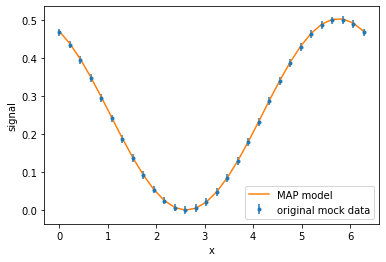

In [9]:
print('MAP model:', end='')
for field in pipeline.MAP_model:
    print('\n',field.name)
    for p, v in field.parameters.items():
        print('\t',p,'\t',v)
print()
plt.errorbar(x, sim_data, err, marker='.', linestyle='none', label='original mock data')
plt.plot(x, pipeline.MAP_simulation[key].global_data[0],  label='MAP model')
plt.xlabel('x'); plt.ylabel('signal'); plt.legend();

## Sampling the posterior



### Nested sampling

#### Dynesty


19637it [11:21, 28.81it/s, batch: 14 | bound: 39 | nc: 3 | ncall: 230771 | eff(%):  8.509 | loglstar: -2.723 < -0.003 < -0.584 | logz: -4.142 +/-  0.101 | stop:  0.999]            



**Posterior report:**

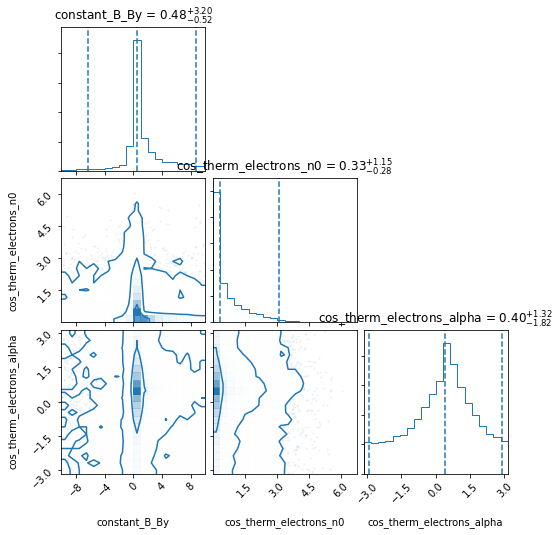

<IPython.core.display.Math object>

**Evidence report:**

<IPython.core.display.Math object>

In [7]:
pipeline();

### MCMC

It is also possible to sample the posterior distribution using the [emcee](https://emcee.readthedocs.io/), a MCMC ensemble sampler.
The disadvantages of this approach is that it may have difficulties with multimodal distributions and does not automatically estimate the evidence. On the other hand,
it allows someone to transfer previous experience/intuition in the use of MCMC to IMAGINE.

In [6]:
pipeline_emcee = img.pipelines.EmceePipeline(run_directory=img.rc['temp_dir']+'/emcee',
                                             factory_list=[B_factory, ne_factory],
                                             simulator=simulator, 
                                             likelihood=likelihood)

In [7]:
pipeline_nested.sampling_controllers = {'n_live_points': 500}

  analysing data from /tmp/imagine_r8qlsc4t/fitting_alt/chains/multinest_.txt



**Posterior report:**

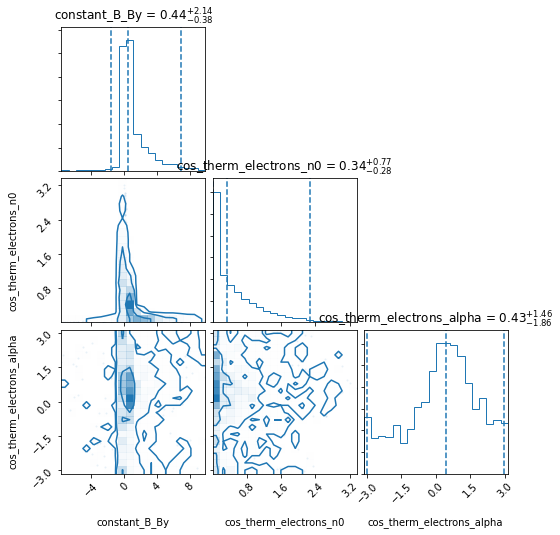

<IPython.core.display.Math object>

**Evidence report:**

<IPython.core.display.Math object>

In [8]:
pipeline_nested();